Deep Learning Assignment 2 Pujan

code reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm


In [3]:

def get_device():
    return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# print("Device is ",get_device())

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def get_output_width(input_width, filter_size, padding, stride):
    return ((input_width - filter_size + 2 * padding)/stride) + 1

print(get_output_width(input_width = 32, filter_size = 5, padding = 0, stride = 1))


28.0


In [30]:

class PujanNet(nn.Module):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__()
        torch.manual_seed(5)
        self.train_results = []
        self.epoch_number = 0
        self.print_interim_data_shapes = False
    
        transform = transforms.Compose(
            [
                #transforms.Grayscale(num_output_channels=3), # with grayscale, overfitting slightly decreased, this should be the result of data augmentation, this is not converting all images to grayscale
                
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        if data_set_name == "cifar_10":
            dataset = torchvision.datasets.CIFAR10(root=download_path, train=True, download=True, transform=transform)
            print('Length of Dataset ', len(dataset))

            train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_data_size, validation_data_size])
            print('Length of Train set ', len(train_dataset))
            print('Length of Val set ', len(val_dataset))
            self.trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
            self.valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

            testset = torchvision.datasets.CIFAR10(root=download_path, train=False, download=True, transform=transform)
            print('Length of Testset ', len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        self.criterion = criterion
        # input channel should be 3 for color image and 1 for grayscale
        self.conv1 = nn.Conv2d(3, 6, 1)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        # mat1 and mat2 shapes cannot be multiplied (4x576 and 400x120)
        # filter = 1, input shape for linear should be 6 * 6,
        # filter = 3, 5, input shape for linear should be 5 * 5
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def display_input_images(self, number_of_images):
        # get some random training images
        dataiter = iter(self.trainloader)
        images, labels = dataiter.next()

        # show images
        imshow(torchvision.utils.make_grid(images))
        # print labels
        print(' '.join(f'{self.classes[labels[j]]:5s}' for j in range(number_of_images)))

    def display_ground_truth_images(self, number_of_images):
        dataiter = iter(self.testloader)
        images, labels = dataiter.next()

        # print images
        imshow(torchvision.utils.make_grid(images))
        print('GroundTruth: ', ' '.join(f'{self.classes[labels[j]]:5s}' for j in range(4)))


    def forward(self, x):
        if self.print_interim_data_shapes:
            print("Initial x shape ", x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # print("After conv1 and maxpool, x shape ", x.shape)

        # First layer
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 1, shape of x is ', x.shape)
        
        # Second layer
        # x = self.pool(F.relu(self.conv2(x)))
        # print("After conv2 and maxpool, x shape ", x.shape)

        x = self.conv2(x)
        # x = self.conv2_bn(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv2, shape of X is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 2, shape of x is ', x.shape)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.print_interim_data_shapes:
            print('After flatten, x shape ', x.shape)
        x = F.relu(self.fc1(x))
        if self.print_interim_data_shapes:
            print('After fc1, x shape ', x.shape)
        x = F.relu(self.fc2(x))
        if self.print_interim_data_shapes:
            print('After fc2, x shape ', x.shape)
        x = self.fc3(x)
        if self.print_interim_data_shapes:
            print('After fc3, x shape ', x.shape)
            break_here_i_want_to_see_shapes
        return x

    def train(self, epoch_number, learning_rate, momentum, optimizer_name):
        optimizer = optim.SGD(self.parameters(), lr= learning_rate, momentum=momentum)
        # if optimizer_name == "sgd": 
        self.epoch_number = epoch_number
        train_results = []

        for epoch in range(epoch_number):  # loop over the dataset multiple times
            # Training phase
            for i, train_data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                train_inputs, train_labels = train_data[0].to(get_device()), train_data[1].to(get_device())
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                train_outputs = self(train_inputs)
                train_loss = self.criterion(train_outputs, train_labels)
                train_loss.backward()
                optimizer.step()
                
            train_accuracy, train_loss_value = self.get_accuracy_and_loss(self.trainloader)

            val_accuracy, val_loss_value = self.get_accuracy_and_loss(self.valloader)

            train_result = {'epoch': epoch, 'train_loss': train_loss_value, 'train_accuracy': train_accuracy, 
                                  'val_loss': val_loss_value, 'val_accuracy': val_accuracy}
            print('Train result ', train_result)
            train_results.append(train_result)

        print('Finished Training')
        self.train_results = train_results
        return train_results

    def plot_loss_and_accuracy_curves(self):
        epoch_numbers = range(self.epoch_number)
        # loss curves : train / val
        # accuracy curves: train / val
 
        # accuracy curve    
        train_accuracies = [x['train_accuracy'] for x in self.train_results]
        val_accuracies = [x['val_accuracy'] for x in self.train_results]    
        plt.plot(train_accuracies, label="train")
        plt.plot(val_accuracies, label="val")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title("Accuracy vs Epoch")
        plt.show()

        # Loss curve    
        train_losses = [x['train_loss'] for x in self.train_results]
        val_losses = [x['val_loss'] for x in self.train_results]    
        plt.plot(train_losses, label="train")
        plt.plot(val_losses, label="val")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Loss vs Epoch")
        plt.show()

    def predictions(self, input_images):
        outputs = self(input_images)
        _, predicted = torch.max(outputs, 1)
        print('Predicted: ', ' '.join(f'{self.classes[predicted[j]]:5s}' for j in range(4)))

    def get_accuracy_score(self, outputs, labels):
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        return correct

    def get_accuracy_and_loss(self, data_loader):
        accuracies = []
        loss_values = []
        total_label_size = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in data_loader:
                # images, labels = data
                images, labels = data[0].to(get_device()), data[1].to(get_device())
                # calculate outputs by running images through the network
                outputs = self(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total_label_size += labels.size(0)
                accuracy_item = (predicted == labels).sum().item()
                accuracies.append(accuracy_item)

                # losses
                loss = self.criterion(outputs, labels)
                loss_item = loss.item()
                loss_values.append(loss_item)
        
        accuracy_score = 100 * np.sum(accuracies) / total_label_size
        loss_value = np.mean(loss_values)
        return (accuracy_score, loss_value)

    def accuracy_in_each_class(self):
    # prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in self.classes}
        total_pred = {classname: 0 for classname in self.classes}

        # again no gradients needed
        with torch.no_grad():
            for data in self.testloader:
                # images, labels = data
                images, labels = data[0].to(get_device()), data[1].to(get_device())
                outputs = self(images)
                _, predictions = torch.max(outputs, 1)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[self.classes[label]] += 1
                    total_pred[self.classes[label]] += 1

        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    




Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 1.4735008252054453, 'train_accuracy': 47.005, 'val_loss': 1.5137039280831814, 'val_accuracy': 46.15}
Finished Training


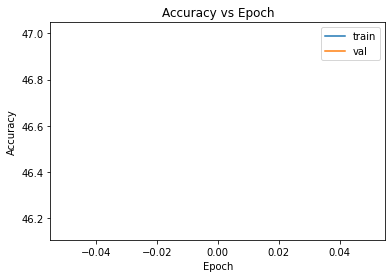

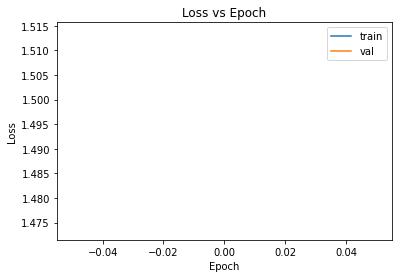

In [31]:

criterion = nn.CrossEntropyLoss()

pujan_net = PujanNet(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
pujan_net = pujan_net.to(get_device())

train_results = pujan_net.train(epoch_number = 1, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
pujan_net.plot_loss_and_accuracy_curves()
# print(train_results)
# pujan_net.accuracy(pujan_net.testloader)

In [ ]:
# Experiments
# Pre processing: Convert into grayscale, since our objective is classification, we don't need  color too,
# try with grayscale image
# Post processing: pooling: Max pooling, average pooling, min pooling. But, practically, max pooling was found to be better by many researchers


# selecting the model
# CNN Architectures (How to choose CNN architecture ????)
#   Number of Layers ??
# Batch Normalization
# Dropout

# Input data enhancements
# Data augmentation

# Hyper parameters
# Loss
# Optimizer
# Learning rate
# Batch size
# Epoch

# even if input size changes, it impacts performance, accuracy
